# Impacto de los indicadores bursatiles en la implementacion de arbol de decisiones. 

## Librerias 

In [50]:
#!pip install scikit-learn
#!pip install xgboost
#!pip install shap
#!pip install talib

In [51]:
# Manipulacion de datos
import numpy as np
import pandas as pd

# Extacción de datos.
import lseg.data as ld

# Generacion de indicadores burstatiles
import talib as ta

# Visualizacion de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Generacion de modelos y metricas
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap 

# Obtencion de fechas
import datetime

import warnings
warnings.filterwarnings("ignore")                                                    

In [52]:
# Lectura de llave
ld.open_session()

<lseg.data.session.Definition object at 0x30f72abd0 {name='workspace'}>

## Recoleccion de datos

In [53]:
# Se define la fecha para la extracción de datos
end = datetime.datetime.now() 
start = end - datetime.timedelta(days=3 * 365)

In [54]:
df = ld.get_history(universe=["MSFT.O"], fields=['TR.CLOSEPRICE', 'TR.OPENPRICE', 'TR.HIGHPRICE', 'TR.LOWPRICE', 'TR.VOLUME', ], interval="1D",
               start = start, end = end)
df = df.rename(columns = {"Close Price":"Close", "Open Price":"Open", "High Price":"High", "Low Price":"Low" }) #renaming the columns of the dataset
df

MSFT.O,Close,Open,High,Low,Volume
Date,,,,,
2022-09-26,237.45,237.045,241.45,236.9,27694190
2022-09-27,236.41,239.98,241.8,234.5,27018732
2022-09-28,241.07,236.81,242.33,234.73,29029679
2022-09-29,237.5,238.89,239.95,234.41,27484233
2022-09-30,232.9,238.29,240.54,232.73,35694832
...,...,...,...,...,...
2025-09-17,510.02,510.62,511.29,505.93,15816585
2025-09-18,508.45,511.49,513.07,507.66,18913696
2025-09-19,517.93,510.56,519.3,510.31,52474093


In [55]:
datos = df[~df.index.duplicated(keep='first')]
datos

MSFT.O,Close,Open,High,Low,Volume
Date,,,,,
2022-09-26,237.45,237.045,241.45,236.9,27694190
2022-09-27,236.41,239.98,241.8,234.5,27018732
2022-09-28,241.07,236.81,242.33,234.73,29029679
2022-09-29,237.5,238.89,239.95,234.41,27484233
2022-09-30,232.9,238.29,240.54,232.73,35694832
...,...,...,...,...,...
2025-09-17,510.02,510.62,511.29,505.93,15816585
2025-09-18,508.45,511.49,513.07,507.66,18913696
2025-09-19,517.93,510.56,519.3,510.31,52474093


## Analisis de datos

### Información de datos

In [56]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 751 entries, 2022-09-26 to 2025-09-23
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   751 non-null    Float64
 1   Open    751 non-null    Float64
 2   High    751 non-null    Float64
 3   Low     751 non-null    Float64
 4   Volume  751 non-null    Int64  
dtypes: Float64(4), Int64(1)
memory usage: 38.9 KB


In [57]:
datos.describe()

MSFT.O,Close,Open,High,Low,Volume
count,751.0,751.0,751.0,751.0,751.0
mean,375.746025,375.620977,378.989771,372.19327,24174504.641811
std,79.125934,79.33745,79.348049,78.95294,9892491.74226
min,214.25,217.55,220.41,213.431,7164543.0
25%,322.695,323.12,326.395,320.295,17772398.5
50%,396.89,395.75,400.62,392.17,21578853.0
75%,426.45,426.08,429.43,422.38,27443832.5
max,535.64,555.225,555.45,531.9,86101994.0


### Missing values

In [58]:
np.where(pd.isnull(datos))

(array([], dtype=int64), array([], dtype=int64))

In [59]:
datos

MSFT.O,Close,Open,High,Low,Volume
Date,,,,,
2022-09-26,237.45,237.045,241.45,236.9,27694190
2022-09-27,236.41,239.98,241.8,234.5,27018732
2022-09-28,241.07,236.81,242.33,234.73,29029679
2022-09-29,237.5,238.89,239.95,234.41,27484233
2022-09-30,232.9,238.29,240.54,232.73,35694832
...,...,...,...,...,...
2025-09-17,510.02,510.62,511.29,505.93,15816585
2025-09-18,508.45,511.49,513.07,507.66,18913696
2025-09-19,517.93,510.56,519.3,510.31,52474093


### Visualizacion de datos

Text(0, 0.5, 'Precio de Cierre')

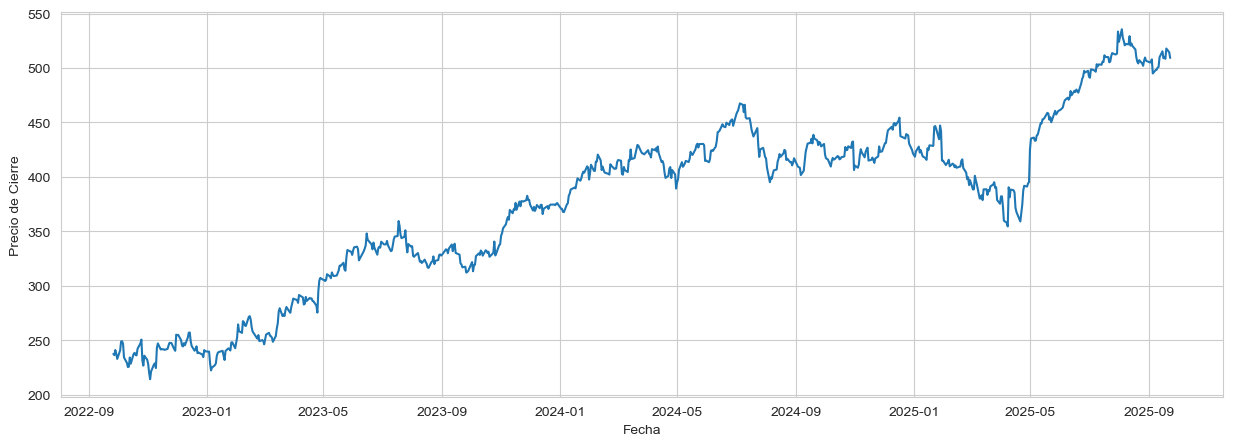

In [60]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=datos, x="Date", y="Close")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre")

## Indicadores Bursatiles


Los indicadores bursátiles son herramientas fundamentales para evaluar el **desempeño de un mercado financiero** o de diversos activos, como acciones, bonos y commodities.

Estos indicadores ofrecen información clave que permite comprender la salud y la dirección del mercado. Inversionistas, analistas financieros y otros profesionales del mercado confían en estos indicadores para tomar decisiones informadas.

En el análisis propuesto, se empleará la biblioteca [Pandas_ta](https://github.com/twopirllc/pandas-ta), que dispone de funciones e indicadores para llevar a cabo análisis técnico.

El resultado de cada indicador será capturado en un DataFrame para su posterior utilización. Además, se presentará de manera visual el comportamiento del indicador, facilitando la interpretación de sus implicaciones en el contexto del análisis.

### Simple Moving Average 

Text(0.5, 0, 'Fecha')

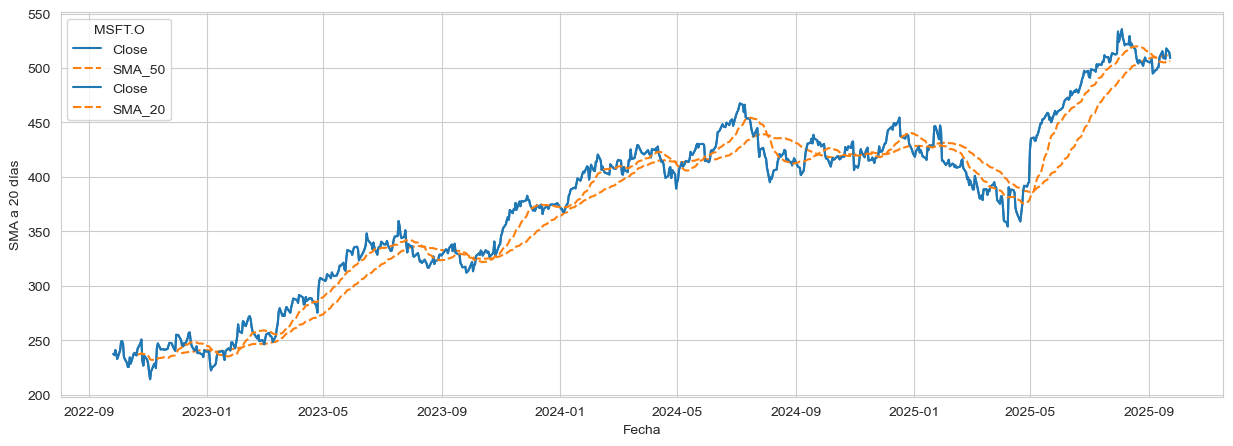

In [61]:
# Se define el indicador
datos["SMA_20"] = ta.SMA(datos.Close, timeperiod=20)
datos["SMA_50"] = ta.SMA(datos.Close, timeperiod=50)

# Se define el tamaño del lienzo
plt.figure(figsize=(15,5))

# Se define los valores a graficar
sns.lineplot(data=datos[["Close", "SMA_50"]])
sns.lineplot(data=datos[["Close", "SMA_20"]])

# Se agregan etiquetas de nombres
plt.ylabel("SMA a 50 días")
plt.ylabel("SMA a 20 días")
plt.xlabel("Fecha")

In [62]:
datos['Signal_SMA'] = np.where((datos['SMA_20'] > datos['SMA_50']), -1, 1)
datos

MSFT.O,Close,Open,High,Low,Volume,SMA_20,SMA_50,Signal_SMA
Date,,,,,,,,
2022-09-26,237.45,237.045,241.45,236.9,27694190,NaN,NaN,1
2022-09-27,236.41,239.98,241.8,234.5,27018732,NaN,NaN,1
2022-09-28,241.07,236.81,242.33,234.73,29029679,NaN,NaN,1
2022-09-29,237.5,238.89,239.95,234.41,27484233,NaN,NaN,1
2022-09-30,232.9,238.29,240.54,232.73,35694832,NaN,NaN,1
...,...,...,...,...,...,...,...,...
2025-09-17,510.02,510.62,511.29,505.93,15816585,505.1155,511.2172,1
2025-09-18,508.45,511.49,513.07,507.66,18913696,505.2520,511.3160,1
2025-09-19,517.93,510.56,519.3,510.31,52474093,505.9365,511.6450,1


## Average Directional Movement Index

y +subir o va a bajar el precio
x1 señal SMA
x2 señal ADX - sólo ADX

Text(0, 0.5, 'Intervalos')

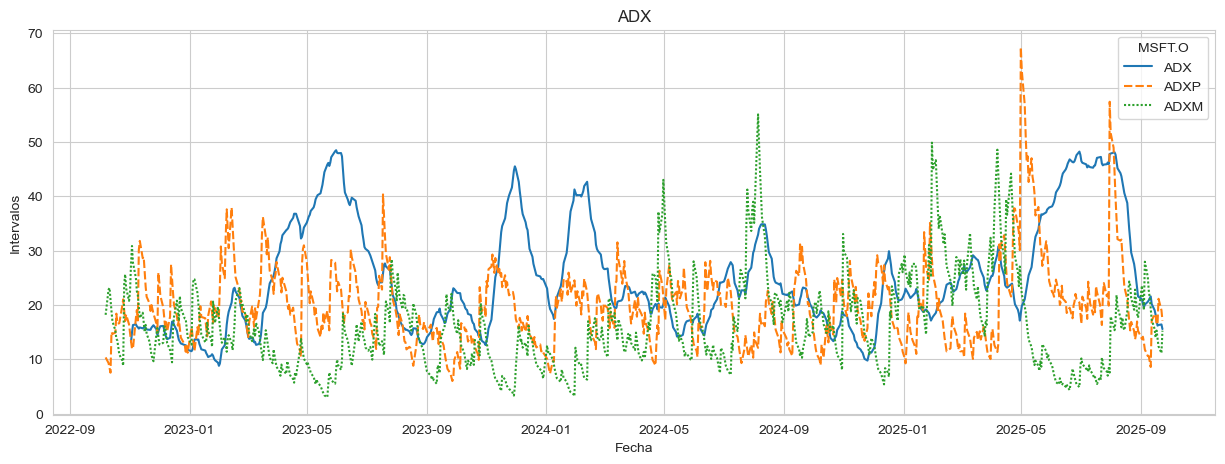

In [63]:
# Se genera el indicador
datos["ADXP"] = ta.PLUS_DM(datos["High"], datos["Low"], timeperiod=10)
datos["ADXM"] = ta.MINUS_DM(datos["High"], datos["Low"], timeperiod=10)
datos['ADX'] = ta.ADX(datos["High"], datos["Low"], datos["Close"], timeperiod=14)

## Se grafica el indicador
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.lineplot(data=datos[["ADX", "ADXP", "ADXM"]], palette="tab10", linewidth=1.5)
plt.title("ADX")
plt.xlabel("Fecha")
plt.ylabel("Intervalos")

##  Absolute Price Oscillator

Text(0.5, 0, 'Fecha')

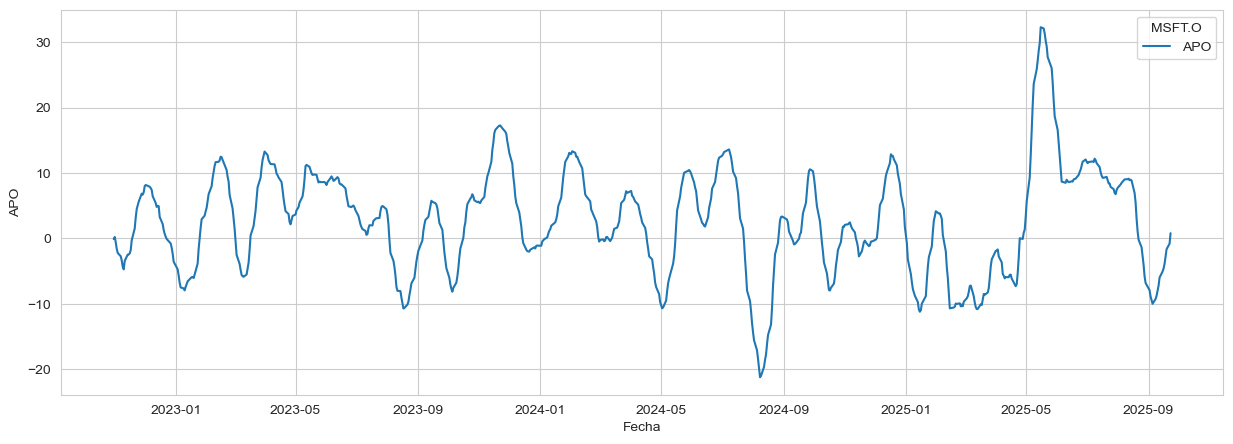

In [64]:
# Se define el indicador
datos["APO"] = ta.APO(datos.Close)

# Se define el tamaño del lienzo
plt.figure(figsize=(15,5))

# Se define los valores a graficar
sns.lineplot(datos[["APO"]])

# Se agregan etiquetas de nombres
plt.ylabel("APO")
plt.xlabel("Fecha")

¿Cómo se intepreta?

`Línea de APO.`

 La línea del APO muestra la diferencia entre dos medias móviles. Si la línea del APO es positiva, significa que la media móvil más corta está por encima de la media móvil más larga, lo que sugiere un impulso alcista. Por otro lado, si la línea del APO es negativa, indica que la media móvil más corta está por debajo de la media móvil más larga, lo que sugiere un impulso bajista.

`Cruces.`

 Los cruces de la línea del APO con la línea cero o con otras líneas de señal pueden utilizarse como señales de compra o venta. Por ejemplo, un cruce ascendente por encima de cero puede considerarse una señal de compra, indicando un cambio potencial hacia un impulso alcista, mientras que un cruce descendente por debajo de cero puede considerarse una señal de venta, indicando un posible cambio hacia un impulso bajista.

## Money Flow Index

Text(0.5, 1.0, 'Money Flow Index')

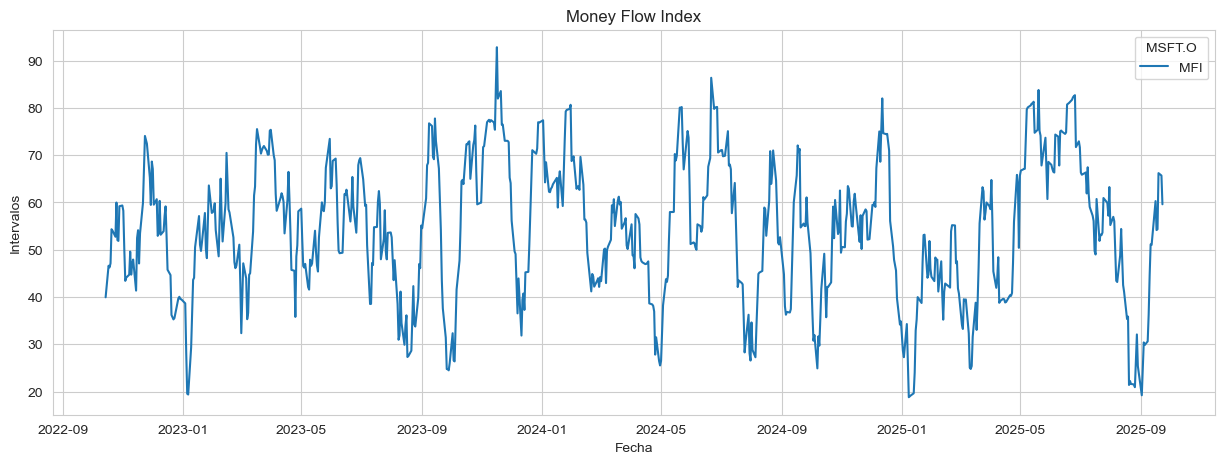

In [65]:
# Se define el indicador
datos["MFI"] = ta.MFI(datos.High, datos.Low, datos.Close, datos.Volume)

# Se define el tamaño del lienzo
plt.figure(figsize=(15,5))

# Se define los valores a graficar
sns.lineplot(datos[["MFI"]])

# Se agregan etiquetas de nombres
plt.ylabel("Intervalos")
plt.xlabel("Fecha")
plt.title("Money Flow Index")

¿Cómo se intepreta?

`Línea de MFI`

Un MFI alto (generalmente por encima de 80) puede indicar que el activo está sobrecomprado y es probable que se produzca una corrección a la baja. Por otro lado, un MFI bajo (generalmente por debajo de 20) puede indicar que el activo está sobrevendido y es probable que se produzca un rebote al alza.

In [66]:
datos['Signal_MFI'] = np.where((datos['MFI'] > 80), -1, 0)
datos['Signal_MFI'] = np.where((datos['MFI'] < 20), 1, datos['Signal_MFI'])
count = datos.groupby('Signal_MFI').size()
print(count)

Signal_MFI
-1     25
 0    720
 1      6
dtype: int64


## SAR Parabolic

Text(0, 0.5, 'Precios')

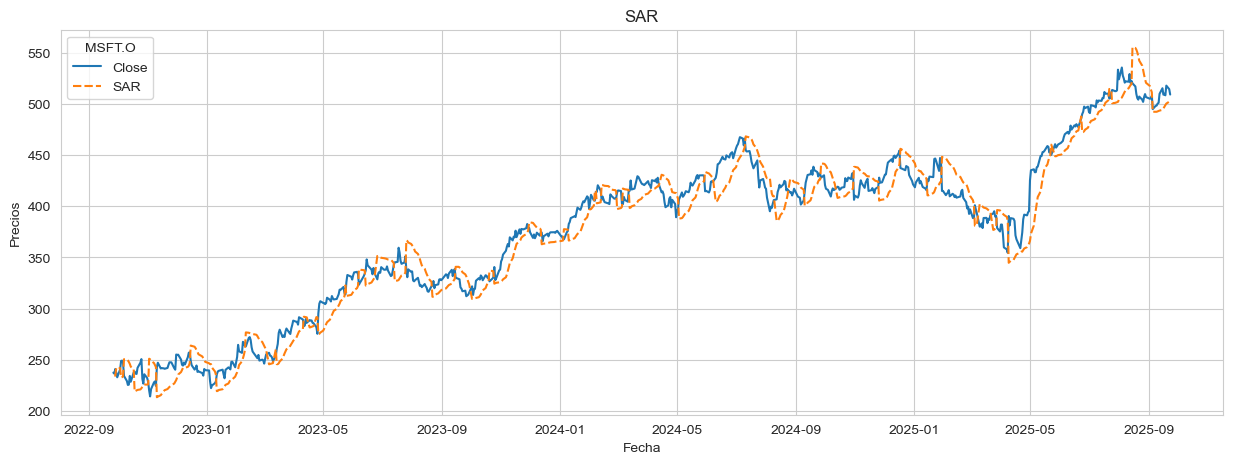

In [67]:
# Se genera el indicador
datos["SAR"] = ta.SAR(datos["High"], datos["Low"], 
            acceleration=0.02, # common value
            maximum=0.2)

# Se grafica el indicador
sns.set_style("whitegrid")
plt.figure(figsize=(15,5))
sns.lineplot(data=datos[["Close", "SAR"]], palette="tab10", linewidth=1.5)
plt.title("SAR")
plt.xlabel("Fecha")
plt.ylabel("Precios")

In [68]:
#A dot is placed below the price when it is trending upward, and above the price when it is trending downward.   
datos['Signal_MFI'] = np.where((((datos['SAR'].fillna(datos['Close'])/datos['Close'])-1) >= 0), -1, 0)
datos['Signal_MFI'] = np.where(((datos['SAR'].fillna(datos['Close'])/datos['Close'])-1) < 0, 1, datos['Signal_MFI'])
count = datos.groupby('Signal_MFI').size()
print(count)



Signal_MFI
-1    297
 1    454
dtype: int64


##  Relative Strength Index(RSI)

Text(0.5, 0, 'Fecha')

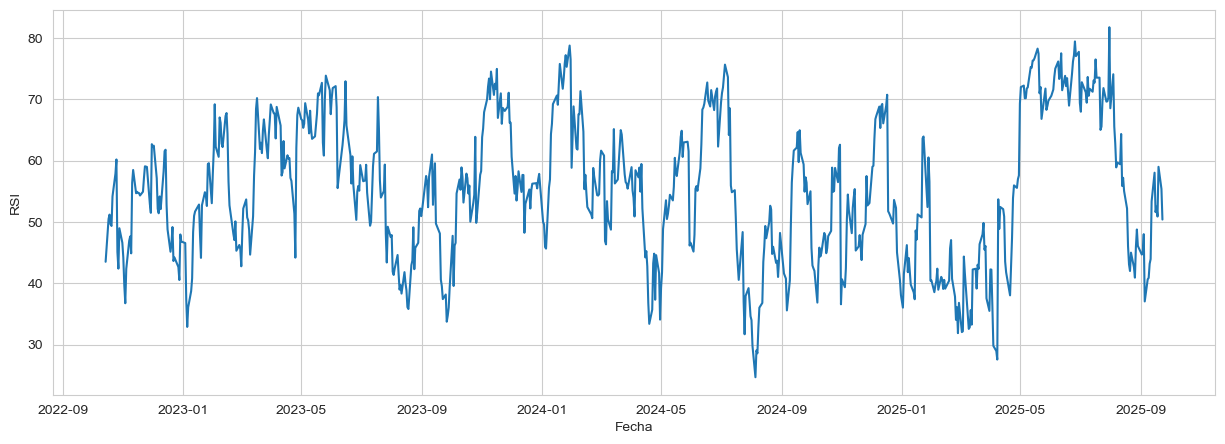

In [69]:
# Se define el indicador
datos["RSI"] = ta.RSI(datos.Close)

# Se define el tamaño del lienzo
plt.figure(figsize=(15,5))

# Se define los valores a graficar
sns.lineplot(data=datos["RSI"])

# Se agregan etiquetas de nombres
plt.ylabel("RSI")
plt.xlabel("Fecha")

In [70]:
    
datos['Signal_RSI'] = np.where((datos['RSI'] > 70), -1, 0)
datos['Signal_RSI'] = np.where((datos['RSI'] < 30), 1, datos['Signal_RSI'])
count = datos.groupby('Signal_RSI').size()
print(count)

Signal_RSI
-1     93
 0    651
 1      7
dtype: int64


`Línea de RSI.`

Un RSI alto (generalmente por encima de 70) puede indicar que el activo está sobrecomprado y es probable que se produzca una corrección a la baja. Por otro lado, un RSI bajo (generalmente por debajo de 30) puede indicar que el activo está sobrevendido y es probable que se produzca un rebote al alza.

## Ultimate Oscillator

Text(0.5, 0, 'Fecha')

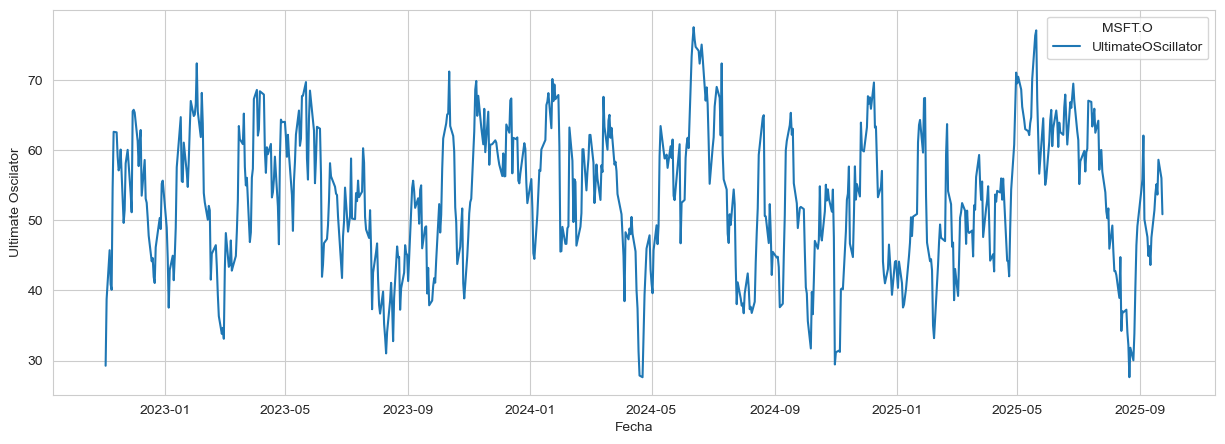

In [71]:
# Se define el indicador
datos["UltimateOScillator"] = ta.ULTOSC(datos.High, datos.Low, datos.Close,
                            timeperiod1=7,
                            timeperiod2=14,
                            timeperiod3=28)

# Se define el tamaño del lienzo
plt.figure(figsize=(15,5))

# Se define los valores a graficar
sns.lineplot(data=datos[["UltimateOScillator"]])

# Se agregan etiquetas de nombres
plt.ylabel("Ultimate Oscilator")
plt.xlabel("Fecha")

In [72]:
    
datos['Signal_UO'] = np.where((datos['UltimateOScillator'] > 70), -1, 0)
datos['Signal_UO'] = np.where((datos['UltimateOScillator'] < 30), 1, datos['Signal_UO'])
count = datos.groupby('Signal_UO').size()
print(count)

Signal_UO
-1     18
 0    728
 1      5
dtype: int64


¿Como se interpreta?

`Valor del Ultimate Oscillator`

Generalmente, se considera que un UO por encima de 70 indica que el activo está sobrecomprado y es probable que se produzca una corrección a la baja, mientras que un UO por debajo de 30 indica que el activo está sobrevendido y es probable que se produzca un rebote al alza.

## Bollinger Bands

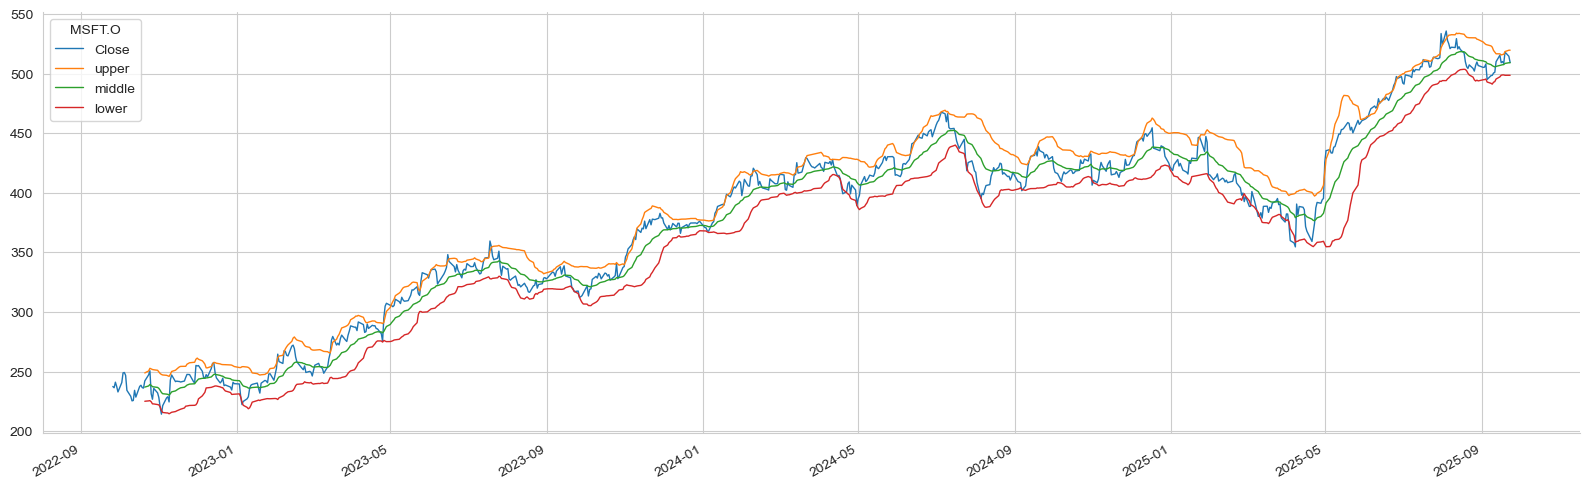

In [73]:
# Se calcula el indicador 
bb = ta.BBANDS(datos["Close"],
                timeperiod=20,
                nbdevup=1.8,    # Deviation multiplier for lower band
                nbdevdn=1.8,    # Deviation multiplier for upper band
                matype=1      # default: SMA
                )
bb_bands = ['upper', 'middle', 'lower']

datos = datos.assign(**dict(zip(bb_bands, bb)))

ax = datos.loc[:, ['Close'] + bb_bands].plot(figsize=(16, 5), lw=1)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [74]:

# Define conditions and replacements
datos['Signal_BB'] = np.where((datos['Close'] > datos['upper'])&datos['upper'].notnull(), -1, 0)
datos['Signal_BB'] = np.where((datos['Close'] < datos['lower'])&datos['lower'].notnull(), 1, datos['Signal_BB'])
count = datos.groupby('Signal_BB').size()
print(count)

Signal_BB
-1     60
 0    668
 1     23
dtype: int64


##  Weighted Moving Average

Text(0.5, 0, 'Fecha')

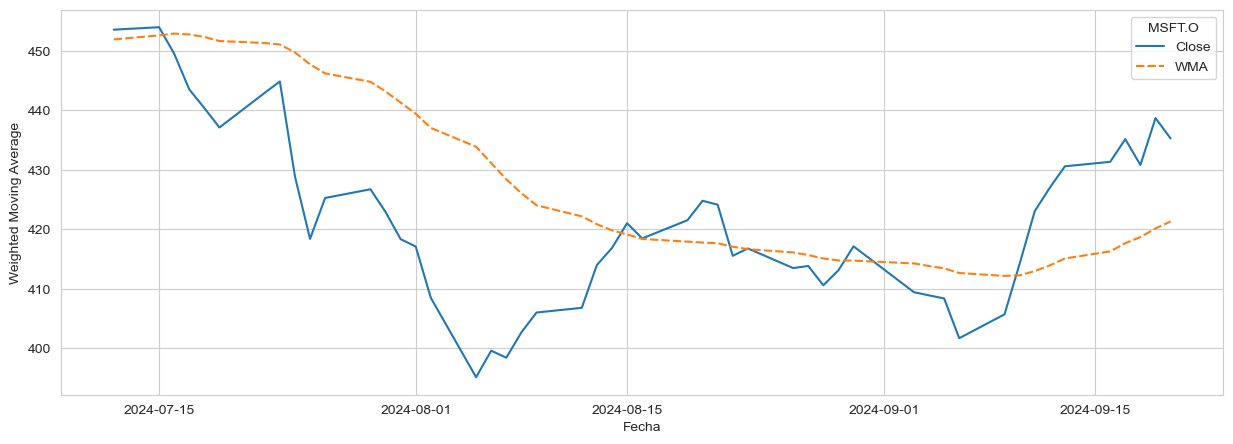

In [75]:
# Se define el indicador
datos["WMA"] = ta.WMA(datos.Close)

# Se define el tamaño del lienzo
plt.figure(figsize=(15,5))

# Se define los valores a graficar
sns.lineplot(data=datos[450:500][["Close", "WMA"]])

# Se agregan etiquetas de nombres
plt.ylabel("Weighted Moving Average")
plt.xlabel("Fecha")

In [76]:
datos['Signal_WMA'] = np.where(~np.isnan(datos['WMA']) & (datos['WMA'] > datos.Close), 1, 0)
datos['Signal_WMA'] = np.where(~np.isnan(datos['WMA']) & (datos['WMA'] < datos.Close), -1, datos['Signal_WMA'])
count = datos.groupby('Signal_WMA').size()
print(count)

Signal_WMA
-1    457
 0     29
 1    265
dtype: int64


¿Cómo se interpreta?

La interpretación de la WMA es similar a la de otras medias móviles, pero con énfasis en los precios más recientes debido a la ponderación que se aplica.

por ejemplo:

`Tendencia`

Cuando la WMA está subiendo, sugiere una tendencia alcista, mientras que cuando está bajando, sugiere una tendencia bajista.

`Indicación de Momentum`.

La pendiente de la WMA puede proporcionar información sobre el impulso del precio. Una WMA inclinada hacia arriba sugiere un impulso alcista, mientras que una WMA inclinada hacia abajo sugiere un impulso bajista.


## Exponential Moving Average 

Text(0.5, 0, 'Fecha')

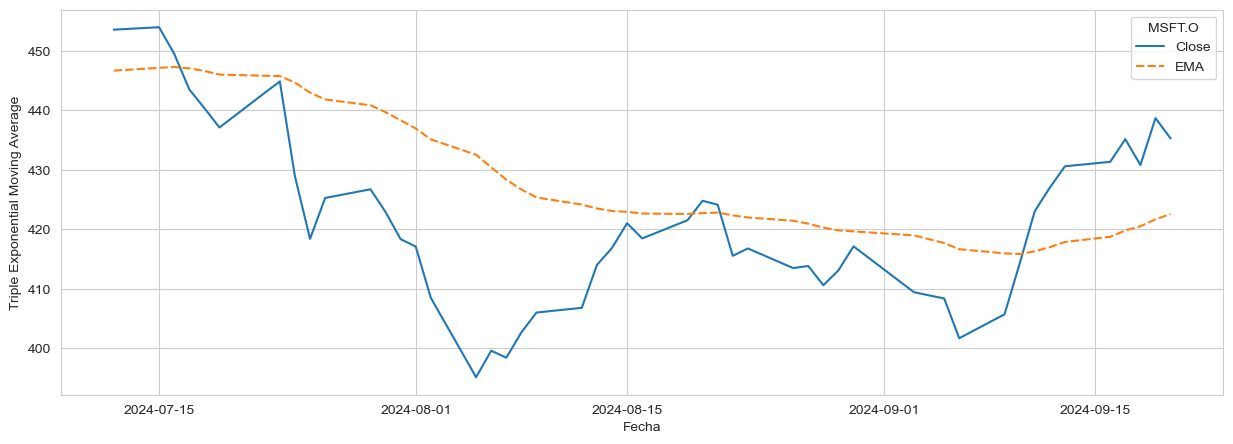

In [77]:
# Se define el indicador
datos["EMA"] = ta.EMA(datos.Close)

# Se define el tamaño del lienzo
plt.figure(figsize=(15,5))

# Se define los valores a graficar
sns.lineplot(datos[450:500][["Close", "EMA"]])

# Se agregan etiquetas de nombres
plt.ylabel("Triple Exponential Moving Average")
plt.xlabel("Fecha")

In [78]:
datos['Signal_EMA'] = np.where(~np.isnan(datos['EMA'].shift(-1)) & (datos['EMA'] > datos["EMA"].shift(-1)), 1, 0)
datos['Signal_EMA'] = np.where(~np.isnan(datos['EMA'].shift(-1)) & (datos['EMA'] < datos["EMA"].shift(-1)), -1, datos['Signal_EMA'])
count = datos.groupby('Signal_EMA').size()
print(count)

Signal_EMA
-1    477
 0     30
 1    244
dtype: int64


El valor de la EMA actual depende del valor de la EMA anterior y del precio actual. Al tener en cuenta el precio actual con un peso mayor, la EMA reacciona más rápido a los cambios recientes en el precio en comparación con la SMA.

`Tendencia`

Cuando la EMA está subiendo, sugiere una tendencia alcista, mientras que cuando está bajando, sugiere una tendencia bajista.

`Indicación de momentum`

 Una EMA inclinada hacia arriba sugiere un impulso alcista, mientras que una EMA inclinada hacia abajo sugiere un impulso bajista.


## Double Exponential Moving Average

Text(0.5, 0, 'Fecha')

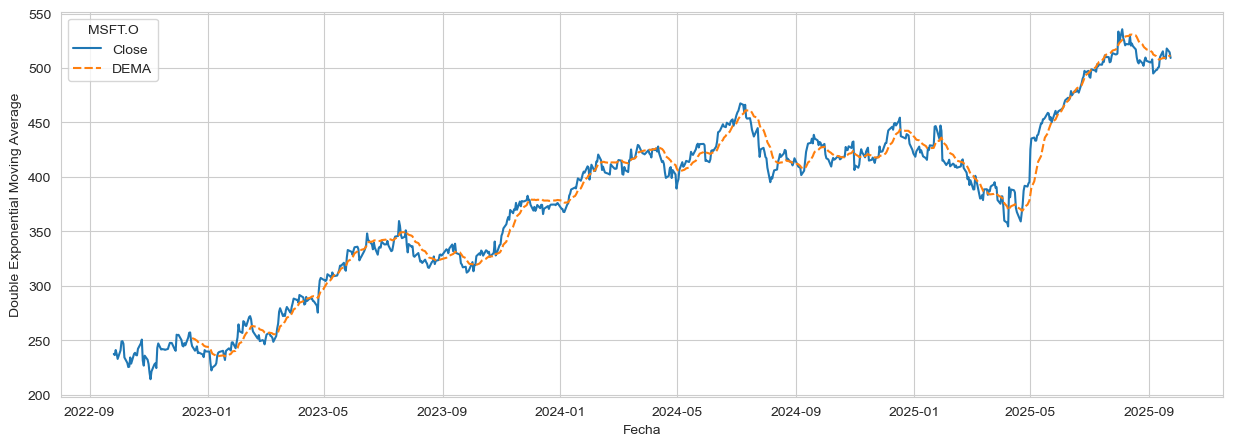

In [79]:
# Se define el indicador
datos["DEMA"] = ta.DEMA(datos.Close)

# Se define el tamaño del lienzo
plt.figure(figsize=(15,5))

# Se define los valores a graficar
sns.lineplot(datos[["Close", "DEMA"]])

# Se agregan etiquetas de nombres
plt.ylabel("Double Exponential Moving Average")
plt.xlabel("Fecha")

In [80]:
datos['Signal_DEMA'] = np.where(~np.isnan(datos['DEMA'].shift(-1)) & (datos['DEMA'] > datos["DEMA"].shift(-1)), 1, 0)
datos['Signal_DEMA'] = np.where(~np.isnan(datos['DEMA'].shift(-1)) & (datos['DEMA'] < datos["DEMA"].shift(-1)), -1, datos['Signal_DEMA'])
count = datos.groupby('Signal_DEMA').size()
print(count)

Signal_DEMA
-1    418
 0     59
 1    274
dtype: int64


La `DEMA` busca reducir aún más el retraso inherente en las medias móviles al proporcionar una respuesta más rápida a los cambios de precio.

La `DEMA tiende a ser más sensible a los cambios en el precio` en comparación con la EMA tradicional, ya que se calcula mediante un proceso de suavizado doble. Esto significa que puede proporcionar señales de compra o venta más tempranas en comparación con otras medias móviles. Sin embargo, debido a su mayor sensibilidad, la DEMA también puede generar más señales falsas en ciertas condiciones del mercado.

Columna Objetivo.

Se identifica la columna objetivo que se pretende predecir, planteándose la interrogante de si es posible prever si el valor de la acción estará por encima de su promedio móvil en un período de 5 días  

In [95]:
## Nuevo indicador

In [96]:
slowk, slowd = ta.STOCH(datos.High,
                           datos.Low,
                           datos.Close,
                           fastk_period=14,
                           slowk_period=3,
                           slowk_matype=0,
                           slowd_period=3,
                           slowd_matype=0)
datos['STOCH'] = slowd / slowk


In [100]:
datos['Signal_STOCH'] = np.where(datos['STOCH'] > 1, 1, 0)
datos['Signal_STOCH'] = np.where(datos['STOCH'] < 1, -1, datos['Signal_STOCH'])
count = datos.groupby('Signal_STOCH').size()
print(count)

Signal_STOCH
-1    363
 0     17
 1    370
dtype: int64


In [101]:
datos['Close_1'] = datos['Close'].shift(-1)
datos['crecimiento'] = np.log(datos['Close'].shift(-1))/np.log(datos['Close'])
datos['precios_lead1'] = datos['crecimiento'].shift(-1)
datos = datos[datos['Close_1'].notna()]
datos["target"] = np.where(datos['crecimiento'] < 1, 0, 1)
datos

MSFT.O,Close,Open,High,Low,Volume,SMA_20,SMA_50,Signal_SMA,ADXP,ADXM,...,EMA,Signal_EMA,DEMA,Signal_DEMA,Close_1,crecimiento,precios_lead1,target,STOCH,Signal_STOCH
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-26,237.45,237.045,241.45,236.9,27694190,NaN,NaN,1,NaN,NaN,...,NaN,0,NaN,0,236.41,0.999198,1.003571,0,NaN,0
2022-09-27,236.41,239.98,241.8,234.5,27018732,NaN,NaN,1,NaN,NaN,...,NaN,0,NaN,0,241.07,1.003571,0.99728,1,NaN,0
2022-09-28,241.07,236.81,242.33,234.73,29029679,NaN,NaN,1,NaN,NaN,...,NaN,0,NaN,0,237.5,0.99728,0.996425,0,NaN,0
2022-09-29,237.5,238.89,239.95,234.41,27484233,NaN,NaN,1,NaN,NaN,...,NaN,0,NaN,0,232.9,0.996425,1.006074,0,NaN,0
2022-09-30,232.9,238.29,240.54,232.73,35694832,NaN,NaN,1,NaN,NaN,...,NaN,0,NaN,0,240.74,1.006074,1.006064,1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-15,515.36,508.79,515.47,507.0,17143786,505.5060,510.7228,1,18.319527,15.571152,...,507.096363,-1,509.095478,-1,509.04,0.998024,1.000309,0,0.749115,-1
2025-09-16,509.04,516.88,517.23,508.6,19711922,505.1030,510.9492,1,18.247575,14.014037,...,507.221759,-1,509.209204,-1,510.02,1.000309,0.999505,1,0.862358,-1
2025-09-17,510.02,510.62,511.29,505.93,15816585,505.1155,511.2172,1,16.422817,15.282633,...,507.402291,-1,509.430398,1,508.45,0.999505,1.002965,0,1.012301,1


In [102]:
datos["target"]

Date
2022-09-26    0
2022-09-27    1
2022-09-28    0
2022-09-29    0
2022-09-30    1
             ..
2025-09-15    0
2025-09-16    1
2025-09-17    0
2025-09-18    1
2025-09-19    0
Name: target, Length: 749, dtype: int64

In [103]:
datos_x = datos.filter(like='Signal', axis=1)
datos_x

MSFT.O,Signal_SMA,Signal_MFI,Signal_RSI,Signal_UO,Signal_BB,Signal_WMA,Signal_EMA,Signal_DEMA,Signal_STOCH
Date,,,,,,,,,
2022-09-26,1,-1,0,0,0,0,0,0,0
2022-09-27,1,1,0,0,0,0,0,0,0
2022-09-28,1,1,0,0,0,0,0,0,0
2022-09-29,1,-1,0,0,0,0,0,0,0
2022-09-30,1,-1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2025-09-15,1,1,0,0,0,-1,-1,-1,-1
2025-09-16,1,1,0,0,0,-1,-1,-1,-1
2025-09-17,1,1,0,0,0,-1,-1,1,1


Se elimina las columnas que no se utilizaran

Se elimina las hileras donde no existan los valores

## Prueba y entrenamiento

Se define el conjunto de datos en datos de entrenamiento y de prueba utilizando la funcion train_split_data de sklearn

In [104]:
X_train, X_test, y_train, y_test = train_test_split(datos_x, # Se selecciona los indicadores, dejando de lado los precios 
                                                    datos.loc[:,"target"], # Se selecciona la columna objetivo
                                                    random_state=42,
                                                    test_size=0.3,
                                                    shuffle=False)


In [105]:
y_test

Date
2024-10-25    0
2024-10-28    1
2024-10-29    1
2024-10-30    0
2024-10-31    1
             ..
2025-09-15    0
2025-09-16    1
2025-09-17    0
2025-09-18    1
2025-09-19    0
Name: target, Length: 225, dtype: int64

Se define los parametros para el Clasificador

Se define el modelo y las metricas de los resultados

In [106]:
from sklearn.ensemble import RandomForestClassifier # or RandomForestRegressor
clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(
    X_train,
    y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [107]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)

print(" ")
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Training Precision: {train_precision:.2f}")
print(" ")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")

 
Training Accuracy: 0.69
Training Precision: 0.68
 
Test Accuracy: 0.63
Test Precision: 0.65


In [108]:
y_test_pred

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1])

In [109]:
y_test_array = np.array(y_test)
y_test_array

array([0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0])

In [110]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test_array, y_test_pred)
metrics.auc(fpr, tpr)

0.6199696582561482

In [111]:
from sklearn.metrics import recall_score

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)
print(" ")
print(f"Training Recall: {train_recall:.2f}")
print(f"Test Recall: {test_recall:.2f}")

 
Training Recall: 0.78
Test Recall: 0.69


Se grafica el nivel de importancia de cada indicador dentro del modelo

In [112]:
import time
start_time = time.time()
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.013 seconds


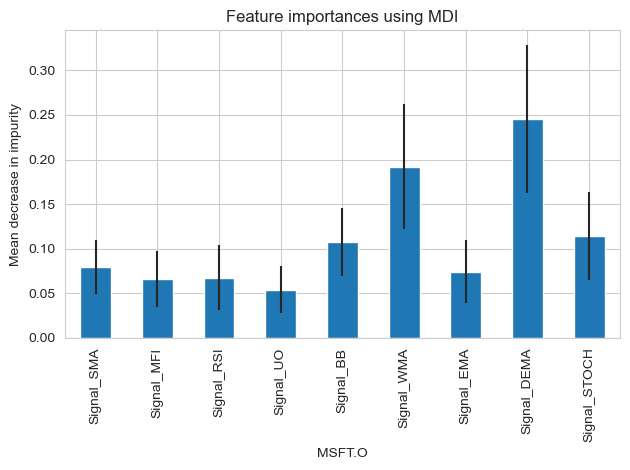

In [113]:
feature_names = datos_x.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()